# 가벼운 모델들 사용
* mobilenet_v3_large <br>
 1. lagre: 연산 속도가 높고 가벼운 모델 -> 정확도가 small에 비해 낮음 <br>
 2. small : 연산속도가 좀더 낮고 무거운 모델 -> 속도가 large에 비해 낮음

* densenet201


# early stopping, scheduler 추가

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/data/"
!unzip -q "/content/drive/MyDrive/data/train.zip"

/content/drive/MyDrive/data


In [ ]:
!pip install torchsampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from torchsampler import ImbalancedDatasetSampler
from tqdm import tqdm
import shutil
import glob
import utils
import numpy
import json 
import torch
import torchvision.transforms as transforms
from utils import CosineAnnealingWarmUpRestarts, EarlyStopping

from autoaugment import ImageNetPolicy, CIFAR10Policy, SVHNPolicy, SubPolicy
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from typing import Tuple, Sequence, Callable
from torch.autograd import Variable
from PIL import Image


In [ ]:
"""
# 효과 없음
# 전체 복사
for path in glob.glob('/content/drive/MyDrive/data/train/*'):
    shutil.copytree(path,f'{path}_focus')
#각 파일 포맷들 이름 변경
for sample in glob.glob('/content/drive/MyDrive/data/train/*focus/*.csv'):
     os.rename(sample,f'{sample[:-4]}_focus.csv')

for sample in glob.glob('/content/drive/MyDrive/data/train/*focus/*.json'):
     os.rename(sample,f'{sample[:-5]}_focus.json')

for sample in glob.glob('/content/drive/MyDrive/data/train/*focus/*.jpg'):
     os.rename(sample,f'{sample[:-4]}_focus.jpg')

# # 객체 영역만 저장
for sample in glob.glob('/content/drive/MyDrive/data/train/*focus'):
     img_path = glob.glob(f'{sample}/*.jpg')[0]
     sample_image = cv2.imread(img_path)
     sample_json = json.load(open(glob.glob(f'{sample}/*.json')[0],'r'))
     points = sample_json['annotations']['bbox'][0]
     x= int(points['x'])
     y= int(points['y'])
     w= int(points['w'])
     h= int(points['h'])
     crop_focus = sample_image[y:y+h,x:x+w,:].copy()
     cv2.imwrite(img_path,crop_focus)
"""

"\n# 효과 없음\n# 전체 복사\nfor path in glob.glob('/content/drive/MyDrive/data/train/*'):\n    shutil.copytree(path,f'{path}_focus')\n#각 파일 포맷들 이름 변경\nfor sample in glob.glob('/content/drive/MyDrive/data/train/*focus/*.csv'):\n     os.rename(sample,f'{sample[:-4]}_focus.csv')\n\nfor sample in glob.glob('/content/drive/MyDrive/data/train/*focus/*.json'):\n     os.rename(sample,f'{sample[:-5]}_focus.json')\n\nfor sample in glob.glob('/content/drive/MyDrive/data/train/*focus/*.jpg'):\n     os.rename(sample,f'{sample[:-4]}_focus.jpg')\n\n# # 객체 영역만 저장\nfor sample in glob.glob('/content/drive/MyDrive/data/train/*focus'):\n     img_path = glob.glob(f'{sample}/*.jpg')[0]\n     sample_image = cv2.imread(img_path)\n     sample_json = json.load(open(glob.glob(f'{sample}/*.json')[0],'r'))\n     points = sample_json['annotations']['bbox'][0]\n     x= int(points['x'])\n     y= int(points['y'])\n     w= int(points['w'])\n     h= int(points['h'])\n     crop_focus = sample_image[y:y+h,x:x+w,:].copy()\n     c

# 사용 패키지

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

In [ ]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob.glob('/content/drive/MyDrive/data/train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [00:47<00:00, 121.77it/s]


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

## CustomDataset 제작

In [ ]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [ ]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [ ]:
transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    ImageNetPolicy(),

    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])
transforms_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])
'''
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),

'''

'\n    transforms.RandomHorizontalFlip(p=0.5),\n    transforms.RandomVerticalFlip(p=0.5),\n\n'

In [ ]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train', transforms= Sequence[Callable]):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder
        self.transforms = transforms

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = Image.fromarray(img) # NumPy array to PIL image
        if self.transforms is not None:
          img = self.transforms(img)

        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : img.clone().detach(),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : img.clone().detach(),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# 하이퍼파라미터 및 변수

In [ ]:
device = torch.device("cuda:0")
batch_size = 64
class_n = len(label_encoder)
learning_rate = 1e-4
# 1e-4 2e-4 1e-3 2e-3
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 50
vision_pretrain = True
save_path = 'best_model.pt'

# 데이터셋 구성

In [ ]:
#train_focus = [path for path in sorted(glob.glob('/content/drive/MyDrive/data/train/*')) if path.endswith('focus')]


In [ ]:
train_origin = [path for path in sorted(glob.glob('/content/drive/MyDrive/data/train/*')) if not path.endswith('focus')]

labelsss = pd.read_csv('/content/drive/MyDrive/data/train.csv')['label']
train, val = train_test_split(train_origin, test_size=0.2, stratify=labelsss)

In [ ]:

train_dataset = CustomDataset(train,transforms=transforms_train)
val_dataset = CustomDataset(val,transforms=transforms_valid)

train_dataloader = torch.utils.data.DataLoader(
                      train_dataset,
                      pin_memory=True,    
                      batch_size=batch_size, 
                      num_workers=4, 
                      shuffle=True)


val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             pin_memory=True,
                                             batch_size=batch_size, 
                                             num_workers=4, shuffle=True)


In [ ]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.densenet201(pretrained=True)

    def forward(self, inputs):
        output = self.model(inputs)
        return output

In [ ]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        #self.lstm = nn.LSTM(max_len, embedding_dim,num_layers=1)
        self.lstm = nn.LSTM(max_len, embedding_dim,num_layers=3,bidirectional=False) #bidirectional 사용, 3층이 가장 최적화

        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output





## 앙상블

In [ ]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)

    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [ ]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

# 학습

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
patience=50
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=100, eta_min=0.001)
early_stopping = EarlyStopping(patience = patience, verbose = True, path =save_path )


In [ ]:

def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score
"""
def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    model.train()
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():
      output = model(img, csv_feature)
      loss = criterion(output, label)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    score = accuracy_function(label, output)
        
    return loss, score
"""
def train_step(batch_item, training):

    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    model.train()
    optimizer.zero_grad()
    with torch.cuda.amp.autocast():

      if BETA > 0 and np.random.random()>0.5: # cutmix 작동될 확률      
        lam = np.random.beta(BETA, BETA)
        rand_index = torch.randperm(img.size()[0]).to(device)
        target_a = label
        target_b = label[rand_index]            
        bbx1, bby1, bbx2, bby2 = utils.rand_bbox(img.size(), lam)
        img[:, :, bbx1:bbx2, bby1:bby2] = img[rand_index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
        output = model(img,csv_feature)
        loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)

      else:
        output = model(img, csv_feature)
        loss = criterion(output, label)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    score = accuracy_function(label, output)
        
    return loss, score





In [ ]:

loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []
BETA=1.0
for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
  
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    
    early_stopping(-val_metric_plot[-1], model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    scheduler.step() 

73it [00:57,  1.27it/s, Epoch=1, Loss=2.527406, Mean Loss=0.784854, Mean F-1=0.651234]
19it [00:15,  1.26it/s, Epoch=1, Val Loss=1.382339, Mean Val Loss=0.866606, Mean Val F-1=0.646450]


Validation loss decreased (inf --> -0.646450).  Saving model ...


73it [00:56,  1.30it/s, Epoch=2, Loss=1.559375, Mean Loss=0.781556, Mean F-1=0.650018]
19it [00:15,  1.26it/s, Epoch=2, Val Loss=0.512207, Mean Val Loss=0.466958, Mean Val F-1=0.773972]


Validation loss decreased (-0.646450 --> -0.773972).  Saving model ...


73it [00:56,  1.29it/s, Epoch=3, Loss=0.285388, Mean Loss=0.768911, Mean F-1=0.667151]
19it [00:15,  1.25it/s, Epoch=3, Val Loss=4.207410, Mean Val Loss=0.860729, Mean Val F-1=0.726611]

EarlyStopping counter: 1 out of 50



73it [00:56,  1.30it/s, Epoch=4, Loss=1.041562, Mean Loss=0.694232, Mean F-1=0.706207]
19it [00:15,  1.25it/s, Epoch=4, Val Loss=0.411499, Mean Val Loss=0.557139, Mean Val F-1=0.719816]

EarlyStopping counter: 2 out of 50



73it [00:56,  1.30it/s, Epoch=5, Loss=1.946552, Mean Loss=0.820775, Mean F-1=0.672354]
19it [00:15,  1.24it/s, Epoch=5, Val Loss=0.152527, Mean Val Loss=0.667593, Mean Val F-1=0.751139]

EarlyStopping counter: 3 out of 50



73it [00:56,  1.29it/s, Epoch=6, Loss=0.030491, Mean Loss=0.706509, Mean F-1=0.689842]
19it [00:15,  1.24it/s, Epoch=6, Val Loss=1.834167, Mean Val Loss=0.775323, Mean Val F-1=0.665152]

EarlyStopping counter: 4 out of 50



73it [00:56,  1.30it/s, Epoch=7, Loss=1.668011, Mean Loss=0.829779, Mean F-1=0.645146]
19it [00:15,  1.24it/s, Epoch=7, Val Loss=0.092758, Mean Val Loss=0.630425, Mean Val F-1=0.801275]


Validation loss decreased (-0.773972 --> -0.801275).  Saving model ...


73it [00:55,  1.30it/s, Epoch=8, Loss=2.801929, Mean Loss=0.594427, Mean F-1=0.737260]
19it [00:15,  1.23it/s, Epoch=8, Val Loss=1.875898, Mean Val Loss=0.849571, Mean Val F-1=0.687062]


EarlyStopping counter: 1 out of 50


73it [00:56,  1.29it/s, Epoch=9, Loss=2.156791, Mean Loss=0.730144, Mean F-1=0.700610]
19it [00:15,  1.23it/s, Epoch=9, Val Loss=1.474365, Mean Val Loss=0.635293, Mean Val F-1=0.702739]

EarlyStopping counter: 2 out of 50



73it [00:56,  1.29it/s, Epoch=10, Loss=0.318592, Mean Loss=0.649473, Mean F-1=0.701989]
19it [00:15,  1.26it/s, Epoch=10, Val Loss=6.185547, Mean Val Loss=0.956951, Mean Val F-1=0.678896]


EarlyStopping counter: 3 out of 50


73it [00:56,  1.30it/s, Epoch=11, Loss=1.567554, Mean Loss=0.719342, Mean F-1=0.672324]
19it [00:15,  1.25it/s, Epoch=11, Val Loss=0.142639, Mean Val Loss=0.607302, Mean Val F-1=0.741663]


EarlyStopping counter: 4 out of 50


73it [00:56,  1.29it/s, Epoch=12, Loss=2.122969, Mean Loss=0.702740, Mean F-1=0.665639]
19it [00:15,  1.26it/s, Epoch=12, Val Loss=1.765435, Mean Val Loss=0.751028, Mean Val F-1=0.731133]

EarlyStopping counter: 5 out of 50



73it [00:56,  1.29it/s, Epoch=13, Loss=0.744025, Mean Loss=0.604106, Mean F-1=0.724948]
19it [00:15,  1.25it/s, Epoch=13, Val Loss=0.566833, Mean Val Loss=0.576072, Mean Val F-1=0.681365]

EarlyStopping counter: 6 out of 50



73it [00:57,  1.28it/s, Epoch=14, Loss=0.736848, Mean Loss=0.793341, Mean F-1=0.696827]
19it [00:15,  1.25it/s, Epoch=14, Val Loss=0.242493, Mean Val Loss=0.556457, Mean Val F-1=0.751228]

EarlyStopping counter: 7 out of 50



73it [00:56,  1.30it/s, Epoch=15, Loss=1.567652, Mean Loss=0.727122, Mean F-1=0.669365]
19it [00:15,  1.25it/s, Epoch=15, Val Loss=1.468567, Mean Val Loss=0.821570, Mean Val F-1=0.668102]

EarlyStopping counter: 8 out of 50



73it [00:56,  1.30it/s, Epoch=16, Loss=2.074334, Mean Loss=0.610563, Mean F-1=0.709145]
19it [00:15,  1.26it/s, Epoch=16, Val Loss=1.783646, Mean Val Loss=0.764217, Mean Val F-1=0.725784]

EarlyStopping counter: 9 out of 50



73it [00:56,  1.30it/s, Epoch=17, Loss=0.508234, Mean Loss=0.757844, Mean F-1=0.654160]
19it [00:15,  1.25it/s, Epoch=17, Val Loss=1.510132, Mean Val Loss=0.671948, Mean Val F-1=0.736373]


EarlyStopping counter: 10 out of 50


73it [00:56,  1.30it/s, Epoch=18, Loss=2.011033, Mean Loss=0.792351, Mean F-1=0.665979]
19it [00:15,  1.25it/s, Epoch=18, Val Loss=0.344849, Mean Val Loss=0.682733, Mean Val F-1=0.725798]


EarlyStopping counter: 11 out of 50


73it [00:56,  1.29it/s, Epoch=19, Loss=1.670498, Mean Loss=0.688313, Mean F-1=0.701394]
19it [00:15,  1.25it/s, Epoch=19, Val Loss=2.645412, Mean Val Loss=0.899880, Mean Val F-1=0.638311]


EarlyStopping counter: 12 out of 50


73it [00:55,  1.31it/s, Epoch=20, Loss=1.742718, Mean Loss=0.686801, Mean F-1=0.709774]
19it [00:15,  1.26it/s, Epoch=20, Val Loss=0.449219, Mean Val Loss=0.760133, Mean Val F-1=0.741761]


EarlyStopping counter: 13 out of 50


73it [00:55,  1.31it/s, Epoch=21, Loss=0.572898, Mean Loss=0.755757, Mean F-1=0.683647]
19it [00:14,  1.27it/s, Epoch=21, Val Loss=2.161939, Mean Val Loss=0.870125, Mean Val F-1=0.622663]


EarlyStopping counter: 14 out of 50


73it [00:55,  1.31it/s, Epoch=22, Loss=0.140587, Mean Loss=0.772807, Mean F-1=0.698903]
19it [00:15,  1.24it/s, Epoch=22, Val Loss=0.204559, Mean Val Loss=0.625156, Mean Val F-1=0.764897]

EarlyStopping counter: 15 out of 50



73it [00:56,  1.29it/s, Epoch=23, Loss=2.933379, Mean Loss=0.802276, Mean F-1=0.709862]
19it [00:15,  1.25it/s, Epoch=23, Val Loss=1.077637, Mean Val Loss=0.554086, Mean Val F-1=0.760267]


EarlyStopping counter: 16 out of 50


73it [00:55,  1.31it/s, Epoch=24, Loss=0.681724, Mean Loss=0.770467, Mean F-1=0.657305]
19it [00:15,  1.25it/s, Epoch=24, Val Loss=3.466015, Mean Val Loss=0.872150, Mean Val F-1=0.668267]

EarlyStopping counter: 17 out of 50



73it [00:55,  1.31it/s, Epoch=25, Loss=0.612835, Mean Loss=0.748390, Mean F-1=0.663738]
19it [00:15,  1.26it/s, Epoch=25, Val Loss=2.462891, Mean Val Loss=0.827400, Mean Val F-1=0.713947]

EarlyStopping counter: 18 out of 50



73it [00:55,  1.30it/s, Epoch=26, Loss=2.922716, Mean Loss=0.817225, Mean F-1=0.690867]
19it [00:15,  1.27it/s, Epoch=26, Val Loss=0.768921, Mean Val Loss=0.816623, Mean Val F-1=0.656110]


EarlyStopping counter: 19 out of 50


73it [00:56,  1.30it/s, Epoch=27, Loss=0.265380, Mean Loss=0.752577, Mean F-1=0.703461]
19it [00:15,  1.26it/s, Epoch=27, Val Loss=1.556519, Mean Val Loss=0.872884, Mean Val F-1=0.637399]


EarlyStopping counter: 20 out of 50


73it [00:56,  1.29it/s, Epoch=28, Loss=0.806720, Mean Loss=0.788459, Mean F-1=0.668478]
19it [00:14,  1.27it/s, Epoch=28, Val Loss=4.816406, Mean Val Loss=0.993166, Mean Val F-1=0.677245]

EarlyStopping counter: 21 out of 50



73it [00:56,  1.30it/s, Epoch=29, Loss=1.546277, Mean Loss=0.815433, Mean F-1=0.671655]
19it [00:14,  1.27it/s, Epoch=29, Val Loss=0.346436, Mean Val Loss=0.815281, Mean Val F-1=0.690069]

EarlyStopping counter: 22 out of 50



73it [00:55,  1.30it/s, Epoch=30, Loss=1.112521, Mean Loss=0.736782, Mean F-1=0.710687]
19it [00:15,  1.26it/s, Epoch=30, Val Loss=0.196106, Mean Val Loss=0.614750, Mean Val F-1=0.741386]

EarlyStopping counter: 23 out of 50



73it [00:56,  1.30it/s, Epoch=31, Loss=2.049903, Mean Loss=0.812776, Mean F-1=0.687414]
19it [00:15,  1.27it/s, Epoch=31, Val Loss=0.579117, Mean Val Loss=0.713262, Mean Val F-1=0.741260]

EarlyStopping counter: 24 out of 50



73it [00:56,  1.30it/s, Epoch=32, Loss=2.299488, Mean Loss=0.861389, Mean F-1=0.667891]
19it [00:15,  1.23it/s, Epoch=32, Val Loss=3.090820, Mean Val Loss=0.777300, Mean Val F-1=0.726226]

EarlyStopping counter: 25 out of 50



73it [00:56,  1.28it/s, Epoch=33, Loss=0.848978, Mean Loss=0.863265, Mean F-1=0.684560]
19it [00:14,  1.27it/s, Epoch=33, Val Loss=2.413574, Mean Val Loss=0.760667, Mean Val F-1=0.727076]

EarlyStopping counter: 26 out of 50



73it [00:56,  1.29it/s, Epoch=34, Loss=0.768540, Mean Loss=0.904371, Mean F-1=0.682022]
19it [00:15,  1.25it/s, Epoch=34, Val Loss=0.802673, Mean Val Loss=0.796646, Mean Val F-1=0.783456]

EarlyStopping counter: 27 out of 50



73it [00:55,  1.31it/s, Epoch=35, Loss=1.644999, Mean Loss=0.872424, Mean F-1=0.617311]
19it [00:15,  1.22it/s, Epoch=35, Val Loss=4.527602, Mean Val Loss=0.900315, Mean Val F-1=0.703329]

EarlyStopping counter: 28 out of 50



73it [00:55,  1.31it/s, Epoch=36, Loss=1.607983, Mean Loss=0.810845, Mean F-1=0.681432]
19it [00:15,  1.26it/s, Epoch=36, Val Loss=0.982666, Mean Val Loss=0.930808, Mean Val F-1=0.722016]

EarlyStopping counter: 29 out of 50



73it [00:56,  1.30it/s, Epoch=37, Loss=0.986084, Mean Loss=0.838035, Mean F-1=0.669265]
19it [00:14,  1.27it/s, Epoch=37, Val Loss=2.052176, Mean Val Loss=0.771026, Mean Val F-1=0.715650]

EarlyStopping counter: 30 out of 50



73it [00:55,  1.31it/s, Epoch=38, Loss=1.255296, Mean Loss=0.763224, Mean F-1=0.694576]
19it [00:15,  1.25it/s, Epoch=38, Val Loss=1.083496, Mean Val Loss=0.780551, Mean Val F-1=0.666935]

EarlyStopping counter: 31 out of 50



73it [00:55,  1.32it/s, Epoch=39, Loss=0.110074, Mean Loss=0.906392, Mean F-1=0.667154]
19it [00:14,  1.28it/s, Epoch=39, Val Loss=0.899872, Mean Val Loss=0.736998, Mean Val F-1=0.770852]

EarlyStopping counter: 32 out of 50



73it [00:55,  1.31it/s, Epoch=40, Loss=1.021335, Mean Loss=0.844513, Mean F-1=0.652832]
19it [00:15,  1.26it/s, Epoch=40, Val Loss=1.576996, Mean Val Loss=0.687345, Mean Val F-1=0.747058]


EarlyStopping counter: 33 out of 50


73it [00:55,  1.31it/s, Epoch=41, Loss=0.230206, Mean Loss=0.767294, Mean F-1=0.653286]
19it [00:15,  1.25it/s, Epoch=41, Val Loss=2.186916, Mean Val Loss=0.863030, Mean Val F-1=0.644493]

EarlyStopping counter: 34 out of 50



73it [00:55,  1.31it/s, Epoch=42, Loss=1.906795, Mean Loss=0.731252, Mean F-1=0.701267]
19it [00:15,  1.27it/s, Epoch=42, Val Loss=1.007812, Mean Val Loss=0.857962, Mean Val F-1=0.721229]

EarlyStopping counter: 35 out of 50



73it [00:55,  1.32it/s, Epoch=43, Loss=2.424573, Mean Loss=0.843579, Mean F-1=0.701051]
19it [00:15,  1.25it/s, Epoch=43, Val Loss=3.306152, Mean Val Loss=0.850652, Mean Val F-1=0.638387]

EarlyStopping counter: 36 out of 50



73it [00:55,  1.31it/s, Epoch=44, Loss=0.320416, Mean Loss=0.981938, Mean F-1=0.634532]
19it [00:15,  1.25it/s, Epoch=44, Val Loss=1.593626, Mean Val Loss=0.822097, Mean Val F-1=0.679584]

EarlyStopping counter: 37 out of 50



73it [00:55,  1.30it/s, Epoch=45, Loss=2.622684, Mean Loss=0.789896, Mean F-1=0.660476]
19it [00:15,  1.25it/s, Epoch=45, Val Loss=3.901471, Mean Val Loss=0.950426, Mean Val F-1=0.720728]

EarlyStopping counter: 38 out of 50



73it [00:55,  1.32it/s, Epoch=46, Loss=0.706575, Mean Loss=0.930397, Mean F-1=0.668000]
19it [00:15,  1.26it/s, Epoch=46, Val Loss=0.748779, Mean Val Loss=0.706937, Mean Val F-1=0.767303]

EarlyStopping counter: 39 out of 50



73it [00:56,  1.30it/s, Epoch=47, Loss=0.792987, Mean Loss=0.972044, Mean F-1=0.632310]
19it [00:15,  1.24it/s, Epoch=47, Val Loss=2.919922, Mean Val Loss=1.043302, Mean Val F-1=0.682937]

EarlyStopping counter: 40 out of 50



73it [00:56,  1.30it/s, Epoch=48, Loss=0.143745, Mean Loss=0.967736, Mean F-1=0.620650]
19it [00:15,  1.25it/s, Epoch=48, Val Loss=4.206055, Mean Val Loss=1.145591, Mean Val F-1=0.651626]

EarlyStopping counter: 41 out of 50



73it [00:55,  1.31it/s, Epoch=49, Loss=0.274168, Mean Loss=0.777870, Mean F-1=0.624300]
19it [00:15,  1.25it/s, Epoch=49, Val Loss=1.047546, Mean Val Loss=0.882003, Mean Val F-1=0.661879]

EarlyStopping counter: 42 out of 50



73it [00:56,  1.30it/s, Epoch=50, Loss=0.785177, Mean Loss=0.828909, Mean F-1=0.672890]
19it [00:15,  1.25it/s, Epoch=50, Val Loss=0.562744, Mean Val Loss=0.942682, Mean Val F-1=0.694439]

EarlyStopping counter: 43 out of 50


In [ ]:

val_loss_plot= list(t.cpu().detach().numpy() for t in val_loss_plot)

In [ ]:
loss_plot = list(t.cpu().detach().numpy() for t in loss_plot)

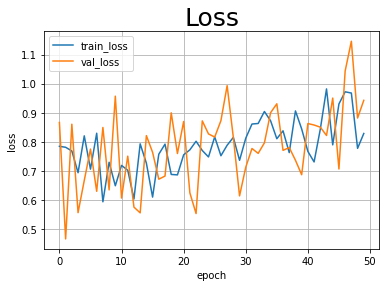

In [ ]:
utils.show_plot(x=loss_plot,y=val_loss_plot,xlabel='epoch',ylabel='loss',title='Loss',plot_label_1='train_loss',plot_label_2='val_loss')

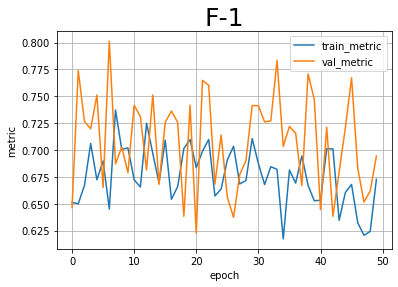

In [ ]:
utils.show_plot(x=metric_plot,y=val_metric_plot,xlabel='epoch',ylabel='metric',title='F-1',plot_label_1='train_metric',plot_label_2='val_metric')